In [7]:
from dotenv import load_dotenv

import cv2
import os
import numpy as np
import json
import albumentations as A
from pathlib import Path
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset

In [8]:
class PathManager:
    """환경 및 모듈 간 규격 클래스"""
    """상황에 맞게 경로와 규격을 수정 후 사용할 것"""
    
    def __init__(self, default_size: int | None = None):
        """dotenv 위치 찾기 + 로드"""
        self.root_path = self._find_root()
        self.dotenv_path = self.root_path / ".env" # 또는 self.dotenv_path = self.root_path / ".env"
        load_dotenv(self.dotenv_path)

        """이미지와 모델 디렉토리 인식"""
        self._images_dir = self.root_path / "data/images"
        self._models_dir = self.root_path / "models"
        self._datas_dir = self.root_path / "data"
        self.default_size = default_size

        self.image_name = None
        self.model_name = None

    def _find_root(self, marker: str=".env") -> Path: # 외부에서 호출할 일 없다.
        """프로젝트 최상단 경로를 찾는 함수"""
        """.env를 마커로 사용"""
        current_cwd = Path().cwd().resolve()
        for parent in current_cwd.parents:
            if (parent / marker).exists():
                return parent

    def get_image_path(self, image_name: str) -> Path:
        """이미지 주소 획득"""
        self.image_name = image_name
        return self._images_dir / image_name
        
    def get_model_path(self, model_name: str) -> Path:
        """모델 주소 획득"""
        self.model_name = model_name
        return self._models_dir / model_name

    def get_data_path(self, data_name: str) -> Path:
        """데이터 주소 획득"""
        self.data_name = data_name
        return self._datas_dir / data_name

def run():
    """앞으로 작업할 모든 작업에서 쓰는 경로 반환 함수"""
    path_manager = PathManager()

    # 기본 경로, 이미지 폴더 경로, 데이터 폴더 경로
    root_path = path_manager.root_path
    images_dir = path_manager._images_dir
    data_dir = path_manager._datas_dir

    # json 경로
    json_path = path_manager.get_data_path("COCO_motorcycle (pixel).json")
    
    # json 로드
    with open (json_path, "r", encoding="utf-8") as f:
        my_json_origin = json.load(f)

    return root_path, images_dir, data_dir, my_json_origin

# root_path: .env 파일의 부모 폴더, images_dir: 이미지 폴더 주소, data_dir: 데이터 폴더 주소, my_json_origin: json파일 객체
root_path, images_dir, data_dir, my_json_origin = run()

In [9]:
# 데이터 검사

all_files = os.listdir(images_dir)
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

image_files = [
    f for f in all_files 
    if f.lower().endswith(valid_extensions)
    and 'save' not in f.lower() 
    and 'fuse' not in f.lower()
]

json_filenames = {img['file_name'] for img in my_json_origin['images']}
final_image_files = [f for f in image_files if f in json_filenames]

print(f"최종 매칭된 이미지 개수: {len(final_image_files)}장")

최종 매칭된 이미지 개수: 200장


In [27]:
import cv2
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset


# 0번부터 5번까지 6개 클래스를 할당, 배경도 언Undrivable에 포함
CLASS_MAP = {
    'Undrivable': 0,
    'Road': 1,
    'Lane Mark': 2,
    'My bike': 3,
    'Rider': 4,
    'Moveable': 5
}
# 역매핑 (ID -> Name)은 필요할 때 내부에서 생성하거나 별도로 정의
ID_TO_NAME = {v: k for k, v in CLASS_MAP.items()}


class DeepLabDataset(Dataset):
    """데이터셋, 이미지 및 마스크크 리사이즈, 정규화, 텐서화 """

    def __init__(self, image_paths, json_data, class_map):
        self.image_paths = image_paths
        self.json_data = json_data
        self.class_map = class_map
        
        # 520x520 리사이즈 및 텐서 변환
        self.transform = A.Compose([
            # 0. 리사이징 (528, 528)
            A.Resize(528, 528, interpolation=cv2.INTER_LINEAR),            
            # 1. 야간 노이즈 대응 (Gaussian Noise) - "야간 데이터의 특성을 고려했습니다"
            A.GaussNoise(p=0.2),            
            # 2. 오토바이의 좌우 주행 가변성 (Horizontal Flip)
            A.HorizontalFlip(p=0.5),            
            # 3. 조명 변화 대응 (Random Brightness/Contrast)
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
            # 4. 정규화
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            # 5. 텐서화
            ToTensorV2()
        ])
        
        # 마스크 전용 리사이즈 (정수 값 유지를 위해 별도 처리하거나 Compose 내에서 mask_interpolation 설정)
        # self.mask_resize = A.Resize(528, 528, interpolation=cv2.INTER_NEAREST)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """마스크 제너레이터 함수로 마스크 생성, 이미지와 마스크에 리사이즈 및 정규화 적용"""
        image_path = self.image_paths[idx]
        
        # 1. 원본 이미지 로드 및 bgr2rgb
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 2. 마스크 생성 (기존에 정의한 6개 클래스 로직)
        # 2. 1920x1080 원본 크기로 먼저 생성
        full_mask = self._generate_full_mask(image_path.name, (1080, 1920))

        # 3. 이미지와 마스크 동시 변환 -> Resize(528, 528) 적용
        # 이 한 줄이 이미지와 마스크를 동기화시킵니다.
        transformed = self.transform(image=image, mask=full_mask)
        
        # 결과물에서 각각 꺼내면 이미 동기화된 상태입니다.
        image = transformed['image']
        mask = transformed['mask']
        
        return image, mask.long()

    def _generate_full_mask(self, file_name, shape):
        """JSON의 좌표를 기반으로 1080x1920 마스크 생성"""
        mask = np.zeros(shape, dtype=np.uint8)
        
        # 1. file_name으로 image_id 찾기
        image_info = next((img for img in self.json_data['images'] if img['file_name'] == file_name), None)
        if image_info is None:
            return mask
        
        image_id = image_info['id']
        
        # 2. 해당 image_id를 가진 모든 annotation 가져오기
        annotations = [ann for ann in self.json_data['annotations'] if ann['image_id'] == image_id]
        
        # 3. 카테고리 ID -> 이름 -> 인덱스(0~5) 매핑
        category_id_to_name = {cat['id']: cat['name'] for cat in self.json_data['categories']}
        
        for ann in annotations:
            cat_name = category_id_to_name.get(ann['category_id'])
            label_idx = self.class_map.get(cat_name)
            
            if label_idx is not None:
                for seg in ann['segmentation']:
                    # COCO 포맷의 폴리곤 [x1, y1, x2, y2...]을 numpy 배열로 변환
                    poly = np.array(seg).reshape((-1, 1, 2)).astype(np.int32)
                    # 해당 영역을 label_idx로 채움
                    cv2.fillPoly(mask, [poly], color=label_idx)                    
        return mask



In [28]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

def get_loaders(images_dir, json_origin, class_map, batch_size=4):
    """위에서 PathManager 인스턴스 들이 반환한 경로 및 객체들을 인자로 입력"""

    # 해당 디렉토리와 하위 디렉토리의 모든 특정 확장자 파일을 검색 후 리스트 생성
    all_files = list(images_dir.glob("**/*.png"))

    # 2. all_files 중 'fuse'나 'save'가 경로(폴더명 포함)에 들어있는 파일 제외 후 원본 이미지만 담긴 리스트 생성
    images_path_origin = sorted([p for p in all_files if "fuse" not in str(p).lower() and "save" not in str(p).lower()])
    
    # 2. 데이터셋 분할 (160 : 20 : 20)
    train_paths, temp_paths = train_test_split(images_path_origin, train_size=160, test_size=40, random_state=42)
    val_paths, test_paths = train_test_split(temp_paths, train_size=20, test_size=20, random_state=42)

    # 3. 데이터셋 인스턴스 생성
    train_dataset = DeepLabDataset(train_paths, json_origin, class_map)
    val_dataset = DeepLabDataset(val_paths, json_origin, class_map)
    test_dataset = DeepLabDataset(test_paths, json_origin, class_map)

    # 4. 데이터로더 생성 (images, masks 구성), (batch, shuffle 결정)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(len(images_path_origin))

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

# 로더 정의 완료 (train(160), val(20), test(20))
train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_loaders(images_dir, my_json_origin, CLASS_MAP)



200


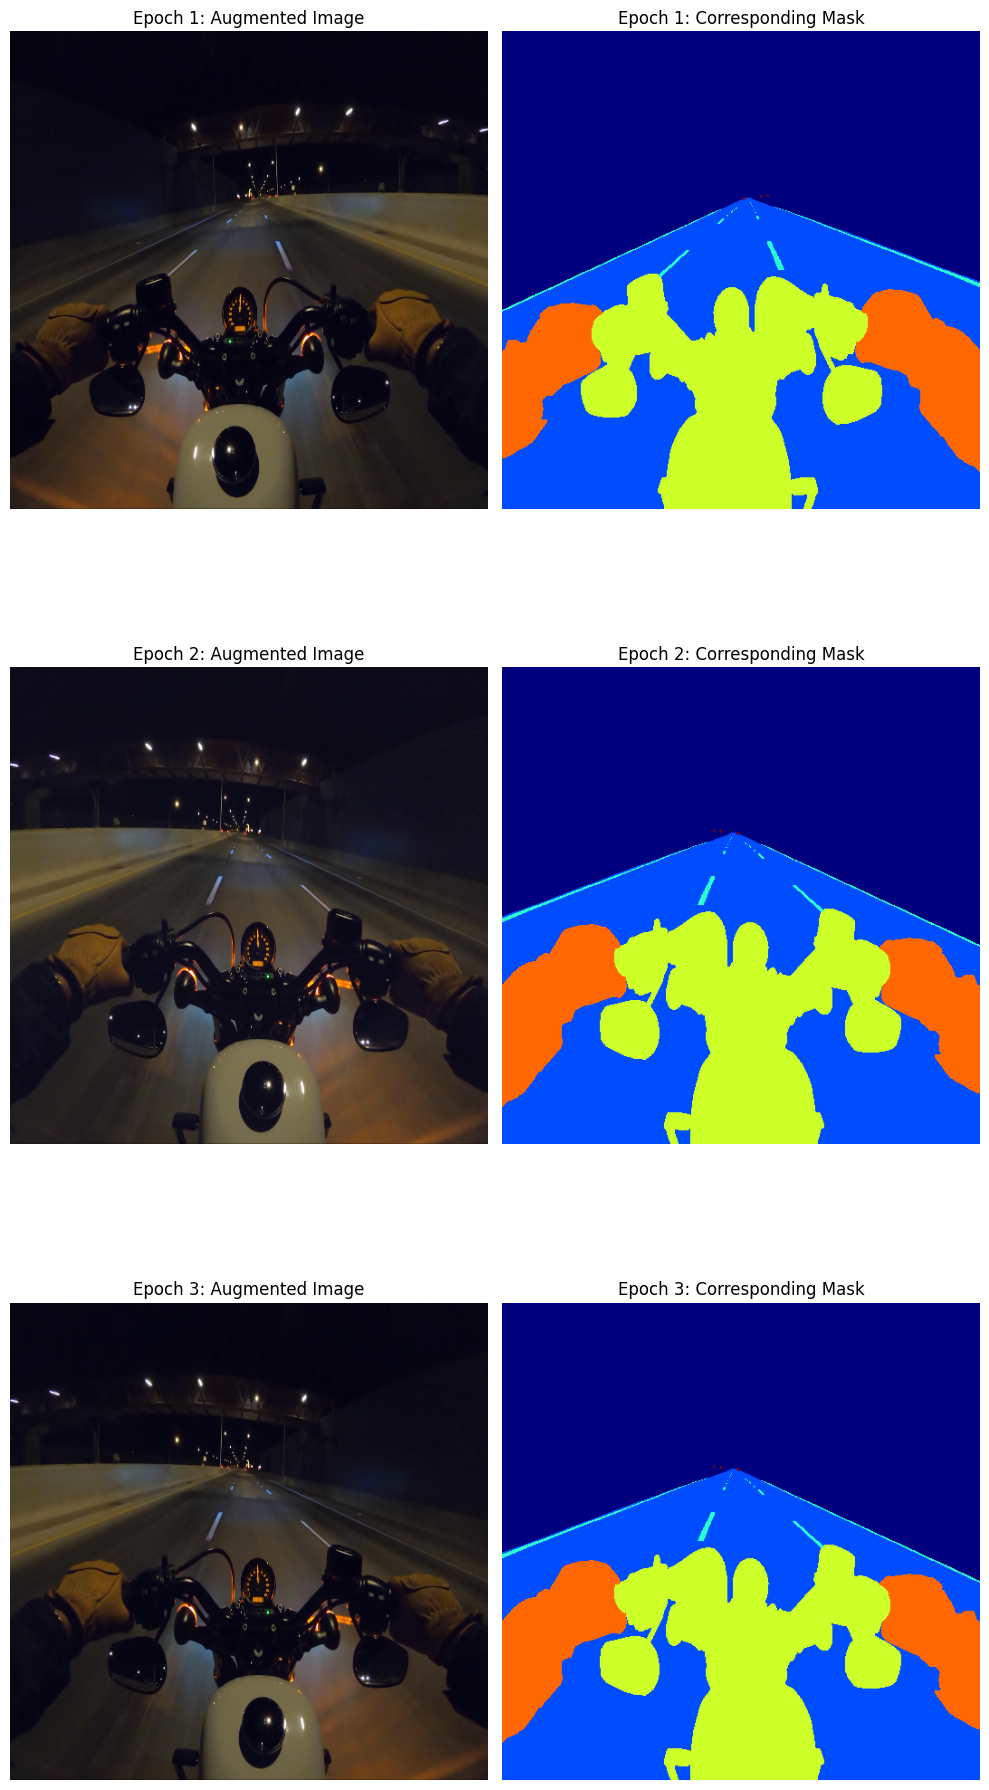

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_augmentation_epochs(dataset, sample_idx=0, num_epochs=3):
    """동일한 샘플이 에포크마다 어떻게 변하는지 시각화"""
    fig, axes = plt.subplots(nrows=num_epochs, ncols=2, figsize=(10, 20))
    
    for epoch in range(num_epochs):
        # 동일한 인덱스를 호출하지만, 내부 transform의 p(확률)에 의해 매번 결과가 다름
        image, mask = dataset[sample_idx]
        
        # 시각화를 위한 역정규화 (Normalize 되돌리기)
        img = image.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        # 마스크 데이터
        mask = mask.numpy()
        
        # 출력
        axes[epoch, 0].imshow(img)
        axes[epoch, 0].set_title(f"Epoch {epoch+1}: Augmented Image")
        axes[epoch, 0].axis('off')
        
        axes[epoch, 1].imshow(mask, cmap='jet')
        axes[epoch, 1].set_title(f"Epoch {epoch+1}: Corresponding Mask")
        axes[epoch, 1].axis('off')
        
    plt.tight_layout()
    plt.show()

# 실행 (이미 생성된 train_ds 사용)
visualize_augmentation_epochs(train_dataset)

In [30]:
import torch

# 1. CUDA 가속 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 현재 활성화된 연산 장치: {device}")

🚀 현재 활성화된 연산 장치: cuda


In [31]:
import segmentation_models_pytorch as smp

# 2. 모델 아키텍처 선언
# 종하 님이 정의한 6개 클래스(0~5)에 맞춰 'classes=6'을 정확히 명시합니다.
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",       # 백본 인코더
    encoder_weights="imagenet",   # ImageNet 사전 학습 가중치 사용
    in_channels=3,                # 입력 채널 (RGB)
    classes=6                     # 출력 클래스 개수
).to(device)

print("✅ DeepLabV3+ 모델 로드 및 GPU 전송 완료")

✅ DeepLabV3+ 모델 로드 및 GPU 전송 완료


In [32]:
import torch.nn.functional as F
import torch.nn as nn


weight_config = {
    'Undrivable': 1.0,
    'Road': 1.0,   
    'Lane Mark': 5.0,  
    'My bike': 1.0,
    'Rider': 1.0,     
    'Moveable': 3.0
}

# 2. CLASS_MAP의 인덱스 순서에 맞춰 텐서로 변환
# sorted(CLASS_MAP, key=CLASS_MAP.get)을 사용하여 인덱스 0부터 5까지 순서를 보장합니다.
weights = torch.tensor(
    [weight_config[name] for name in sorted(CLASS_MAP, key=CLASS_MAP.get)],
    dtype=torch.float32
).to(device)


class DiceCELoss(nn.Module):
    """
    CrossEntropy와 Dice Loss를 결합하여 
    픽셀 분류 정확도와 영역 일치도를 동시에 최적화합니다.
    """
    def __init__(self, weight: torch.Tensor = None, lambda_dice: float = 0.5):
        super(DiceCELoss, self).__init__()
        self.ce = nn.CrossEntropyLoss(weight=weight)
        self.lambda_dice = lambda_dice

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # Standard Cross Entropy
        ce_loss = self.ce(inputs, targets)
        
        # Dice Loss 계산을 위한 전처리
        num_classes = inputs.size(1)
        # targets를 One-hot으로 변환 (B, H, W) -> (B, C, H, W)
        targets_one_hot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()
        # inputs에 Softmax 적용
        inputs_soft = F.softmax(inputs, dim=1)
        
        # Dice Loss 공식: 1 - (2 * intersection + eps) / (sum + eps)
        intersection = (inputs_soft * targets_one_hot).sum(dim=(0, 2, 3))
        union = inputs_soft.sum(dim=(0, 2, 3)) + targets_one_hot.sum(dim=(0, 2, 3))
        
        dice_score = (2. * intersection + 1e-7) / (union + 1e-7)
        dice_loss = 1.0 - dice_score.mean()
        
        # 최종 결합
        return ce_loss + (self.lambda_dice * dice_loss)

# 적용


In [33]:
import torch.nn as nn
import torch.optim as optim


criterion = DiceCELoss(weight=weights)
# criterion = nn.CrossEntropyLoss()

# 0: Undrivable, 1: Road, 2: Lane Mark, 3: My bike, 4: Rider, 5: Moveable
# weights = torch.tensor([1.0, 1.0, 5.0, 1.0, 2.0, 2.0]).to(device)
# criterion = nn.CrossEntropyLoss(weight=weights)
# print("⚖️ 클래스 불균형 해소를 위한 가중치 적용 완료 (Lane Mark x5.0)")

# 4. Optimizer: 수렴 속도가 빠르고 과적합 방지에 유리한 AdamW
# 초기 학습률(lr)은 전이 학습의 안정성을 위해 1e-4로 보수적으로 설정했습니다.
optimizer = optim.AdamW(
    model.parameters(), 
    lr=1e-4, 
    weight_decay=1e-2
)

# 5. Scheduler: 학습이 진행될수록 정교하게 가중치를 튜닝하도록 조절
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

In [34]:
from typing import Dict, Any

def get_metrics(
    model: torch.nn.Module, 
    loader: torch.utils.data.DataLoader, 
    device: torch.device, 
    num_classes: int = 6
) -> Dict[str, Any]:
    """
    Confusion Matrix를 활용하여 Segmentation 지표를 효율적으로 계산합니다.
    """
    model.eval()
    conf_matrix = torch.zeros((num_classes, num_classes), device=device)
    
    with torch.inference_mode():  # no_grad보다 최신이며 빠름
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            # Confusion Matrix 업데이트 (이 방식이 훨씬 빠르고 전문적입니다)
            # 2D 연산을 1D로 펼쳐 bincount로 계산하는 테크닉
            conf_matrix += torch.bincount(
                num_classes * masks.view(-1) + preds.view(-1),
                minlength=num_classes**2
            ).reshape(num_classes, num_classes)

    eps = 1e-7
    tp = torch.diag(conf_matrix)
    fp = conf_matrix.sum(dim=0) - tp
    fn = conf_matrix.sum(dim=1) - tp

    iou = tp / (tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    miou = iou.mean().item()

    return {
        'miou': miou,
        'iou': iou.cpu(),
        'precision': precision.cpu(),
        'recall': recall.cpu()
    }

In [35]:
class EarlyStopping:
    def __init__(self, patience=5, path='best_deeplab_night.pth'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_miou, model):
        if self.best_score is None:
            self.best_score = val_miou
            self.save_checkpoint(model)
        elif val_miou < self.best_score:
            self.counter += 1
            print(f"📉 EarlyStopping: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_miou
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)
        print(f"⭐ Best Model Saved! (mIoU: {self.best_score:.4f})")

In [36]:
import wandb

# 1. WandB 초기화 (이 셀을 먼저 실행해야 합니다!)
wandb.init(
    project="Dlthon_Motorcycle_Night_Ride", # 프로젝트 이름
    name="DeepLabV3_ResNet50_2st_Run",     # 실험 이름 (매번 바꿔주면 좋습니다)
    config={
        "learning_rate": 1e-4,
        "epochs": 50,
        "batch_size": 4,
        "architecture": "DeepLabV3_ResNet50"
    }
)

IoU/Lane Mark,▁▁▄▄▅▄▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▆▇█▇▇████▇▇█████
IoU/Moveable,▁▂▄▅▇▆▇▅▆▇▆▄▅▆▇▇▆▇▆▇▆▇██▇▇▆█▆▇▇█▇▆▇█▇█▇█
IoU/My bike,▁▄▂▅▅▆▆▅▆▇▇▅▇▆▇▇▇▇▆██▇█▇▇▇██▇█▇█▇▇▇▇▇█▇▇
IoU/Rider,▁▄▂▅▆▅▆▆▆▇▇▆▆▆▇▇▆▇▇██▇▇▇▅▆▇█▇█▇█▆█▇▇▇█▆▇
IoU/Road,▁▄▃▅▅▅▆▆▆▇▇▅▆▆▇▇▆▇▇▇▇▇▇▇▆▇█▇▇█▇█▇▇▇▇██▇▇
IoU/Undrivable,▁▂▄▆▆▇▇▇▇▇▆▆▆▆▇▇▇▇▆▇▆▇▇▇▇█▇▇▇█▇█▇█▇███▇█
batch_loss,█▅▆▅▅▃▂▂▃▃▂▂▂▂▂▂▂▃▂▂▂▁▁▂▁▂▁▂▁▂▂▂▁▁▁▂▂▁▁▁
learning_rate,█████████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
train_avg_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_miou,▁▃▃▅▆▅▆▆▆▇▇▆▆▆▇▇▆▇▇▇▇▇█▇▆▇▇█▇█▇█▇▇▇▇██▇█
IoU/Lane Mark,0.51929


In [37]:
import wandb
from tqdm import tqdm

def train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=50
):
    early_stopping = EarlyStopping(patience=10)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        # 1. batch_idx 에러 수정을 위해 enumerate 추가
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for batch_idx, (images, masks) in pbar:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            # 배치 로그 (실시간)
            wandb.log({
                "batch_loss": loss.item()
            })
            
            train_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")
        
        avg_train_loss = train_loss / len(train_loader)
        
        # 2. 중복 제거: get_metrics 하나로 검증 지표 모두 해결
        # 만약 get_metrics가 loss를 반환하지 않는다면, 그 안에서 계산하도록 수정 권장
        metrics = get_metrics(model, val_loader, device) 
        val_miou = metrics['miou']
        class_ious = metrics['iou']
        
        # 3. 노란 줄의 원인이었던 validate 호출 삭제 및 통합 로깅
        log_dict = {
            "train_avg_loss": avg_train_loss,
            "val_miou": val_miou,
            "learning_rate": scheduler.get_last_lr()[0]
        }
        
        # 클래스별 IoU 동적 추가
        for i, iou_val in enumerate(class_ious):
            cls_name = ID_TO_NAME.get(i, f"Class_{i}")
            log_dict[f"IoU/{cls_name}"] = iou_val
            
        wandb.log(log_dict)
        
        scheduler.step()
        
        print(f"📈 Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | mIoU: {val_miou:.4f}")

        # --- Early Stopping ---
        early_stopping(val_miou, model)
        if early_stopping.early_stop:
            print("🛑 Early stopping triggered. Training halted.")
            break
            
    print(f"🏁 Final Best mIoU: {early_stopping.best_score:.4f}")

    print("-" * 30)
    print(f"{'Class Name':<15} | {'IoU':<10}")
    print("-" * 30)
    for i, iou_val in enumerate(class_ious):
        cls_name = ID_TO_NAME[i] if i < len(ID_TO_NAME) else f"Class {i}"
        print(f"{cls_name:<15} | {iou_val:.4f}")
    print("-" * 30)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device)

Epoch 1/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.02it/s, loss=0.9315]


📈 Epoch [1/50] | Train Loss: 1.4746 | mIoU: 0.4894
⭐ Best Model Saved! (mIoU: 0.4894)


Epoch 2/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.98it/s, loss=0.6918]


📈 Epoch [2/50] | Train Loss: 0.8598 | mIoU: 0.5982
⭐ Best Model Saved! (mIoU: 0.5982)


Epoch 3/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.98it/s, loss=0.5927]


📈 Epoch [3/50] | Train Loss: 0.6766 | mIoU: 0.5927
📉 EarlyStopping: 1 / 10


Epoch 4/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.05it/s, loss=0.4461]


📈 Epoch [4/50] | Train Loss: 0.5839 | mIoU: 0.6667
⭐ Best Model Saved! (mIoU: 0.6667)


Epoch 5/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.89it/s, loss=0.4803]


📈 Epoch [5/50] | Train Loss: 0.5050 | mIoU: 0.6859
⭐ Best Model Saved! (mIoU: 0.6859)


Epoch 6/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.92it/s, loss=0.4299]


📈 Epoch [6/50] | Train Loss: 0.4538 | mIoU: 0.7049
⭐ Best Model Saved! (mIoU: 0.7049)


Epoch 7/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.96it/s, loss=0.3633]


📈 Epoch [7/50] | Train Loss: 0.4312 | mIoU: 0.6675
📉 EarlyStopping: 1 / 10


Epoch 8/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.99it/s, loss=0.3432]


📈 Epoch [8/50] | Train Loss: 0.4026 | mIoU: 0.6898
📉 EarlyStopping: 2 / 10


Epoch 9/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.04it/s, loss=0.5388]


📈 Epoch [9/50] | Train Loss: 0.3975 | mIoU: 0.6984
📉 EarlyStopping: 3 / 10


Epoch 10/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.99it/s, loss=0.4653]


📈 Epoch [10/50] | Train Loss: 0.3466 | mIoU: 0.7152
⭐ Best Model Saved! (mIoU: 0.7152)


Epoch 11/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.81it/s, loss=0.2745]


📈 Epoch [11/50] | Train Loss: 0.3364 | mIoU: 0.7366
⭐ Best Model Saved! (mIoU: 0.7366)


Epoch 12/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.75it/s, loss=0.3922]


📈 Epoch [12/50] | Train Loss: 0.3184 | mIoU: 0.7252
📉 EarlyStopping: 1 / 10


Epoch 13/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.91it/s, loss=0.3644]


📈 Epoch [13/50] | Train Loss: 0.3214 | mIoU: 0.7509
⭐ Best Model Saved! (mIoU: 0.7509)


Epoch 14/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.93it/s, loss=0.2676]


📈 Epoch [14/50] | Train Loss: 0.3017 | mIoU: 0.7021
📉 EarlyStopping: 1 / 10


Epoch 15/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.05it/s, loss=0.4208]


📈 Epoch [15/50] | Train Loss: 0.2882 | mIoU: 0.7141
📉 EarlyStopping: 2 / 10


Epoch 16/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.87it/s, loss=0.3603]


📈 Epoch [16/50] | Train Loss: 0.2935 | mIoU: 0.7223
📉 EarlyStopping: 3 / 10


Epoch 17/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.89it/s, loss=0.3183]


📈 Epoch [17/50] | Train Loss: 0.2737 | mIoU: 0.7585
⭐ Best Model Saved! (mIoU: 0.7585)


Epoch 18/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.84it/s, loss=0.2508]


📈 Epoch [18/50] | Train Loss: 0.2656 | mIoU: 0.7376
📉 EarlyStopping: 1 / 10


Epoch 19/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  5.00it/s, loss=0.3666]


📈 Epoch [19/50] | Train Loss: 0.2623 | mIoU: 0.7599
⭐ Best Model Saved! (mIoU: 0.7599)


Epoch 20/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.99it/s, loss=0.2661]


📈 Epoch [20/50] | Train Loss: 0.2579 | mIoU: 0.7405
📉 EarlyStopping: 1 / 10


Epoch 21/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.03it/s, loss=0.1882]


📈 Epoch [21/50] | Train Loss: 0.2396 | mIoU: 0.7528
📉 EarlyStopping: 2 / 10


Epoch 22/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.99it/s, loss=0.2603]


📈 Epoch [22/50] | Train Loss: 0.2473 | mIoU: 0.7618
⭐ Best Model Saved! (mIoU: 0.7618)


Epoch 23/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.00it/s, loss=0.1577]


📈 Epoch [23/50] | Train Loss: 0.2275 | mIoU: 0.7351
📉 EarlyStopping: 1 / 10


Epoch 24/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.97it/s, loss=0.2590]


📈 Epoch [24/50] | Train Loss: 0.2246 | mIoU: 0.7768
⭐ Best Model Saved! (mIoU: 0.7768)


Epoch 25/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.00it/s, loss=0.1970]


📈 Epoch [25/50] | Train Loss: 0.2169 | mIoU: 0.7752
📉 EarlyStopping: 1 / 10


Epoch 26/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.10it/s, loss=0.1885]


📈 Epoch [26/50] | Train Loss: 0.2070 | mIoU: 0.7770
⭐ Best Model Saved! (mIoU: 0.7770)


Epoch 27/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.90it/s, loss=0.2569]


📈 Epoch [27/50] | Train Loss: 0.2148 | mIoU: 0.7315
📉 EarlyStopping: 1 / 10


Epoch 28/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.99it/s, loss=0.1928]


📈 Epoch [28/50] | Train Loss: 0.2117 | mIoU: 0.7737
📉 EarlyStopping: 2 / 10


Epoch 29/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.06it/s, loss=0.1694]


📈 Epoch [29/50] | Train Loss: 0.2057 | mIoU: 0.7762
📉 EarlyStopping: 3 / 10


Epoch 30/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.94it/s, loss=0.1903]


📈 Epoch [30/50] | Train Loss: 0.2006 | mIoU: 0.7591
📉 EarlyStopping: 4 / 10


Epoch 31/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.88it/s, loss=0.1634]


📈 Epoch [31/50] | Train Loss: 0.2084 | mIoU: 0.7611
📉 EarlyStopping: 5 / 10


Epoch 32/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.89it/s, loss=0.2128]


📈 Epoch [32/50] | Train Loss: 0.1945 | mIoU: 0.7595
📉 EarlyStopping: 6 / 10


Epoch 33/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.94it/s, loss=0.1567]


📈 Epoch [33/50] | Train Loss: 0.2020 | mIoU: 0.7412
📉 EarlyStopping: 7 / 10


Epoch 34/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.03it/s, loss=0.1610]


📈 Epoch [34/50] | Train Loss: 0.1841 | mIoU: 0.7758
📉 EarlyStopping: 8 / 10


Epoch 35/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.97it/s, loss=0.1315]


📈 Epoch [35/50] | Train Loss: 0.1983 | mIoU: 0.7806
⭐ Best Model Saved! (mIoU: 0.7806)


Epoch 36/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.94it/s, loss=0.2012]


📈 Epoch [36/50] | Train Loss: 0.1792 | mIoU: 0.7647
📉 EarlyStopping: 1 / 10


Epoch 37/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.98it/s, loss=0.1718]


📈 Epoch [37/50] | Train Loss: 0.1921 | mIoU: 0.7818
⭐ Best Model Saved! (mIoU: 0.7818)


Epoch 38/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.86it/s, loss=0.1496]


📈 Epoch [38/50] | Train Loss: 0.1816 | mIoU: 0.7554
📉 EarlyStopping: 1 / 10


Epoch 39/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.12it/s, loss=0.1566]


📈 Epoch [39/50] | Train Loss: 0.1815 | mIoU: 0.7560
📉 EarlyStopping: 2 / 10


Epoch 40/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.16it/s, loss=0.1420]


📈 Epoch [40/50] | Train Loss: 0.1830 | mIoU: 0.7833
⭐ Best Model Saved! (mIoU: 0.7833)


Epoch 41/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.98it/s, loss=0.2249]


📈 Epoch [41/50] | Train Loss: 0.1889 | mIoU: 0.7799
📉 EarlyStopping: 1 / 10


Epoch 42/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.95it/s, loss=0.1449]


📈 Epoch [42/50] | Train Loss: 0.1792 | mIoU: 0.7743
📉 EarlyStopping: 2 / 10


Epoch 43/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.98it/s, loss=0.1673]


📈 Epoch [43/50] | Train Loss: 0.1789 | mIoU: 0.7667
📉 EarlyStopping: 3 / 10


Epoch 44/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.20it/s, loss=0.1522]


📈 Epoch [44/50] | Train Loss: 0.1690 | mIoU: 0.7825
📉 EarlyStopping: 4 / 10


Epoch 45/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.23it/s, loss=0.1601]


📈 Epoch [45/50] | Train Loss: 0.1813 | mIoU: 0.7629
📉 EarlyStopping: 5 / 10


Epoch 46/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.25it/s, loss=0.2567]


📈 Epoch [46/50] | Train Loss: 0.1755 | mIoU: 0.7886
⭐ Best Model Saved! (mIoU: 0.7886)


Epoch 47/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.14it/s, loss=0.1426]


📈 Epoch [47/50] | Train Loss: 0.1790 | mIoU: 0.7685
📉 EarlyStopping: 1 / 10


Epoch 48/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.85it/s, loss=0.1427]


📈 Epoch [48/50] | Train Loss: 0.1805 | mIoU: 0.7747
📉 EarlyStopping: 2 / 10


Epoch 49/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.82it/s, loss=0.1718]


📈 Epoch [49/50] | Train Loss: 0.1789 | mIoU: 0.7804
📉 EarlyStopping: 3 / 10


Epoch 50/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.94it/s, loss=0.1390]


📈 Epoch [50/50] | Train Loss: 0.1799 | mIoU: 0.7545
📉 EarlyStopping: 4 / 10
🏁 Final Best mIoU: 0.7886
------------------------------
Class Name      | IoU       
------------------------------
Undrivable      | 0.9081
Road            | 0.8221
Lane Mark       | 0.4427
My bike         | 0.8910
Rider           | 0.8360
Moveable        | 0.6271
------------------------------


In [38]:
import torch
from tqdm import tqdm

def evaluate_test_performance(model, test_loader, device, weight_path=None):
    """
    최종 테스트셋을 사용하여 모델의 mIoU 및 클래스별 성능을 평가합니다.
    """
    # 1. 베스트 가중치 로드 (저장된 경로가 있을 경우)
    if weight_path:
        model.load_state_dict(torch.load(weight_path, map_location=device))
        print(f"✅ 가중치 로드 완료: {weight_path}")

    # 2. 모델을 평가 모드로 전환 (Dropout, BatchNormalization 동작 고정)
    model.eval()
    
    # 3. 성능 측정을 위한 추론 루프
    print("🧪 테스트셋 추론 및 mIoU 계산 시작...")
    
    # 기존에 사용하던 get_metrics가 있다면 이를 활용하거나, 
    # 아래와 같이 직접 루프를 돌려 상세 지표를 산출합니다.
    test_metrics = get_metrics(model, test_loader, device)
    
    val_miou = test_metrics['miou']
    class_ious = test_metrics['iou']

    # 4. 결과 리포팅
    print("\n" + "="*40)
    print(f"🏁 [FINAL TEST RESULT] mIoU: {val_miou:.4f}")
    print("="*40)
    
    print(f"{'Class Name':<15} | {'IoU Score':<10}")
    print("-" * 30)
    
    for i, iou_val in enumerate(class_ious):
        # CLASS_MAP 기반으로 이름 매핑
        cls_name = ID_TO_NAME.get(i, f"Class {i}")
        print(f"{cls_name:<15} | {iou_val:.4f}")
    
    print("-" * 30)
    return test_metrics

# 실행 예시
# weight_path = "best_model.pth" (학습 시 EarlyStopping으로 저장된 파일)
results = evaluate_test_performance(model, test_loader, device, weight_path="best_deeplab_night.pth")

✅ 가중치 로드 완료: best_deeplab_night.pth
🧪 테스트셋 추론 및 mIoU 계산 시작...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5272\1244371823.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path, map_location=d


🏁 [FINAL TEST RESULT] mIoU: 0.7770
Class Name      | IoU Score 
------------------------------
Undrivable      | 0.9274
Road            | 0.8377
Lane Mark       | 0.3989
My bike         | 0.9411
Rider           | 0.9252
Moveable        | 0.6319
------------------------------


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5272\214829592.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_deeplab_night.pth"))


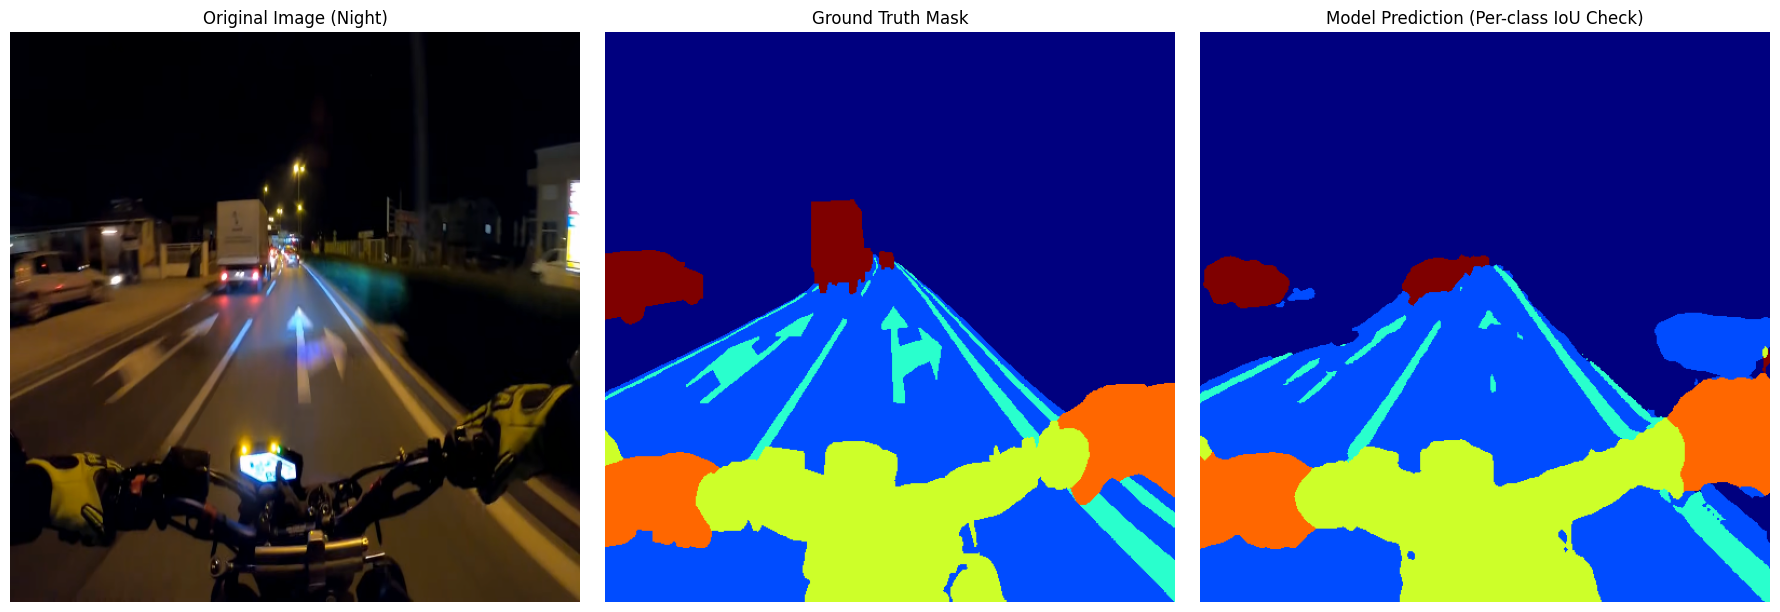

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(model, dataset, device, sample_idx=0):
    model.load_state_dict(torch.load("best_deeplab_night.pth"))
    model.eval()
    
    # 1. 데이터 가져오기
    image_tensor, mask_target = dataset[sample_idx]
    
    # 2. 모델 추론
    with torch.no_grad():
        input_tensor = image_tensor.unsqueeze(0).to(device)
        output = model(input_tensor)
        mask_pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    
    # 3. 시각화를 위한 역정규화
    img_show = image_tensor.permute(1, 2, 0).numpy()
    img_show = img_show * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_show = np.clip(img_show, 0, 1)
    
    # 4. 시각화 (원본 | 정답 | 예측)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(img_show)
    axes[0].set_title("Original Image (Night)")
    axes[0].axis('off')
    
    # 정답 마스크 (Lane Mark는 특정 색으로 강조됨)
    axes[1].imshow(mask_target, cmap='jet', vmin=0, vmax=5)
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')
    
    # 모델 예측 마스크
    axes[2].imshow(mask_pred, cmap='jet', vmin=0, vmax=5)
    axes[2].set_title(f"Model Prediction (Per-class IoU Check)")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# 실행: 검증 데이터셋 중 하나를 골라 확인
visualize_prediction(model, test_dataset, device, sample_idx=18)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5272\1944655719.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_deeplab_night.pth"))


🧪 P-R 분석을 위한 추론 시작 (이 작업은 다소 시간이 소요될 수 있습니다)...


c:\Users\ADMIN\Documents\projects\team\Dlthon_01_Motocycle_Night_Ride\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ADMIN\Documents\projects\team\Dlthon_01_Motocycle_Night_Ride\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ADMIN\Documents\projects\team\Dlthon_01_Motocycle_Night_Ride\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ADMIN\Documents\projects\team\Dlthon_01_Motocycle_Night_Ride\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(byt

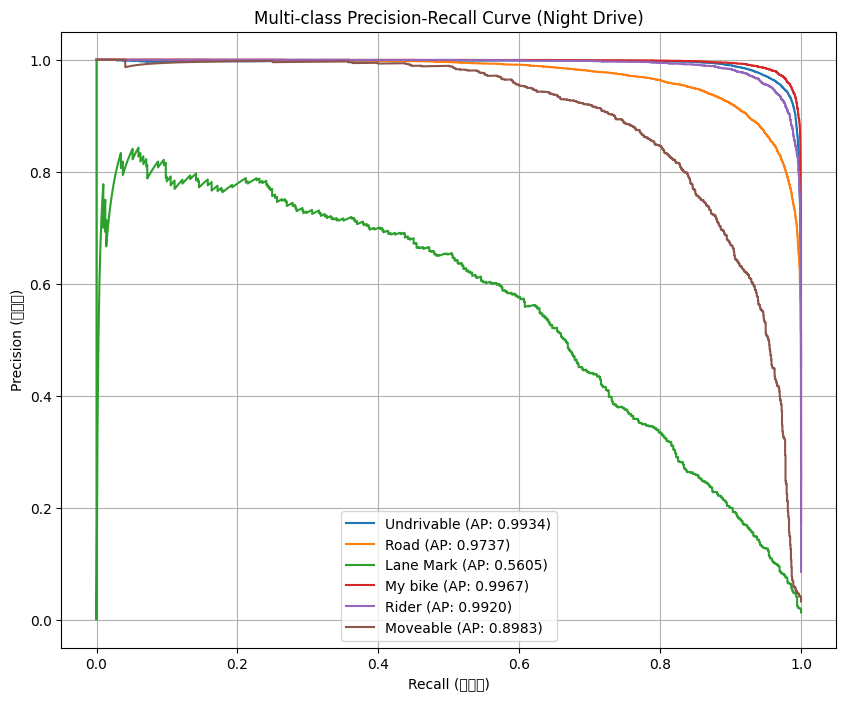

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curves(model, loader, device, num_classes=6, class_names=None):
    model.load_state_dict(torch.load("best_deeplab_night.pth"))
    model.eval()
    
    # 각 클래스별로 실제 값과 예측 확률을 저장할 리스트
    all_targets = [[] for _ in range(num_classes)]
    all_probs = [[] for _ in range(num_classes)]
    
    print("🧪 P-R 분석을 위한 추론 시작 (이 작업은 다소 시간이 소요될 수 있습니다)...")
    
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            # Softmax를 통과시켜 확률값(0~1)으로 변환
            probs = torch.softmax(outputs, dim=1)
            
            for cls in range(num_classes):
                # 해당 클래스에 대한 정답(1)과 오답(0) 바이너리 마스크
                target_cls = (masks == cls).float().cpu().numpy().flatten()
                prob_cls = probs[:, cls, :, :].cpu().numpy().flatten()
                
                # 메모리 효율을 위해 샘플링 (모든 픽셀을 다 넣으면 RAM 부족 위험)
                # 1/100 정도만 샘플링해도 경향성 파악에는 충분합니다.
                indices = np.random.choice(len(target_cls), len(target_cls)//100, replace=False)
                all_targets[cls].extend(target_cls[indices])
                all_probs[cls].extend(prob_cls[indices])

    # 그래프 그리기
    plt.figure(figsize=(10, 8))
    for cls in range(num_classes):
        precision, recall, _ = precision_recall_curve(all_targets[cls], all_probs[cls])
        ap = average_precision_score(all_targets[cls], all_probs[cls])
        
        name = class_names[cls] if class_names else f"Class {cls}"
        plt.plot(recall, precision, label=f'{name} (AP: {ap:.4f})')

    plt.xlabel('Recall (재현율)')
    plt.ylabel('Precision (정밀도)')
    plt.title('Multi-class Precision-Recall Curve (Night Drive)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# 실행 예시
CLASS_NAMES = ["Undrivable", "Road", "Lane Mark", "My bike", "Rider", "Moveable"]
plot_pr_curves(model, test_loader, device, num_classes=6, class_names=CLASS_NAMES)